In [407]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from portfolio_functions import *
from sklearn.covariance import EmpiricalCovariance

In [408]:
#load dataframe
df = pd.read_csv("gp_data_1986_to_2015.csv")
#preview
df.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.56,7.92,2.38,-1.20,-0.86,5.55,2.14,3.91,...,0.78,-1.11,0.85,3.80,4.61,1.91,5.60,2.48,1.67,-0.09
1,198602,7.13,0.53,13.98,7.89,11.68,7.71,12.20,10.72,8.28,...,7.47,2.71,8.34,9.98,8.68,10.61,7.03,8.85,7.21,9.27
2,198603,4.88,0.60,2.74,7.84,10.89,9.17,11.52,5.65,6.86,...,4.96,-0.11,0.04,-1.15,4.18,5.61,3.22,7.41,9.11,6.42
3,198604,-1.31,0.52,5.24,-0.57,4.44,-2.92,3.64,3.91,8.36,...,3.33,3.87,3.55,2.69,-2.50,-0.93,-2.64,1.70,-0.70,3.86
4,198605,4.62,0.49,1.08,8.55,7.95,6.37,10.16,3.16,5.91,...,5.41,1.01,-0.75,2.51,6.66,5.07,0.70,5.52,11.95,4.89


## 1. Data Exploration and Analysis

First, we will reinforce the tools we have learned in the class and construct diversified portfolios among
the 43 industries.

### 1.1. Pre-processing

Calculate the excess return of the 43 industry portfolios. (Note that the excess return of the
market portfolio is already provided.) Subsequently, we will work with the excess returns directly
and treat the riskless rate as zero. Also, you may also treat each industry portfolio as an
individual asset.


In [409]:
#directly convert original monthly returns to excess returns; subtract rf from rf so risk-free rate is 0
df.iloc[:, 2:] = df.iloc[:, 2:].sub(df.iloc[:, 2], axis = 0)
df.head()

,Month,Mkt-RF,RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
0,198601,0.65,0.0,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,...,0.22,-1.67,0.29,3.24,4.05,1.35,5.04,1.92,1.11,-0.65
1,198602,7.13,0.0,13.45,7.36,11.15,7.18,11.67,10.19,7.75,...,6.94,2.18,7.81,9.45,8.15,10.08,6.50,8.32,6.68,8.74
2,198603,4.88,0.0,2.14,7.24,10.29,8.57,10.92,5.05,6.26,...,4.36,-0.71,-0.56,-1.75,3.58,5.01,2.62,6.81,8.51,5.82
3,198604,-1.31,0.0,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,...,2.81,3.35,3.03,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34
4,198605,4.62,0.0,0.59,8.06,7.46,5.88,9.67,2.67,5.42,...,4.92,0.52,-1.24,2.02,6.17,4.58,0.21,5.03,11.46,4.40


### 1.2. Basic Portfolio Construction and In-sample analysis

1. Suppose you are asked to allocate your investment among the 43 industries. Use the 1986-2015
historical data, construct the following three portfolios:
<br>
• The equally weighted portfolio (EWP);
<br>
• The tangency portfolio (TAN);
<br>
• The global minimum variance portfolio (GMV).

In [410]:
#calculate expected return and covariance matrix
expected_rtn = estimate_mu(df.iloc[:, 3:])
cov_matrix = estimate_V(df.iloc[:, 3:])

#form portfolios
tangency_wt = tangency(expected_rtn, cov_matrix)
gmv_wt = gmv(cov_matrix)
ewp_wt = ewp(43)

2. Calculate the realized (in-sample) expected returns, standard deviations, Sharpe ratios, and
betas of every 43 industry portfolio, as well as the market portfolio (MKT), EWP, TAN, and
GMV.

In [411]:
#calculate monthly returns for each portfolio
df["Tangency"] = df.iloc[:, 3:46] @ tangency_wt
df["GMV"] = df.iloc[:, 3:46] @ gmv_wt
df["EWP"] = df.iloc[:, 3:46] @ ewp_wt

#dictionary of portfolio weights to be used later
wt = {
    "43": tangency_wt,
    "44": gmv_wt,
    "45": ewp_wt
}

output = {}

#calculate sigma for each asset (excl mkt)
for i in range(46):
    col = df.columns[i + 3]
    cov = EmpiricalCovariance().fit(df.iloc[:, [1, i + 3]]).covariance_
    beta = cov[0, 1]/cov[0,0]

    if i < 43:
        portfolio_wt = np.zeros(43)
        portfolio_wt[i] += 1
        perf_summary  = evaluate_portfolio_performance_on_data(portfolio_wt, df.iloc[:, 3:46])
    else:
        perf_summary = evaluate_portfolio_performance_on_data(wt[f"{i}"], df.iloc[:, 3:46])

    output[col] = [perf_summary['Er'], perf_summary['sigma'], perf_summary['Sharpe'], beta]

#calculate stats for market portfolio
Er_mkt = df["Mkt-RF"].mean()
Sigma_mkt = df.iloc[:, 1].std(ddof = 0)
Sharpe_mkt = Er_mkt/Sigma_mkt
beta_mkt = 1
output["Mkt"] = [Er_mkt, Sigma_mkt, Sharpe_mkt, beta_mkt]

#output dataframe
output = pd.DataFrame.from_dict(output, orient = 'index', columns = ['Er', 'Sigma', 'Sharpe', 'Beta'])

Deliverable: In a 3 by 4 table, summarize the three in-sample performance metrics (i.e., expected return,
standard deviation, and Sharpe ratio) of the four portfolios (MKT, EWP, TAN, and GMV).

In [412]:
output.loc[["Mkt", "EWP", "Tangency", "GMV"],["Er", "Sigma", "Sharpe"]]

,Er,Sigma,Sharpe
Mkt,0.636361,4.478294,0.142099
EWP,0.718348,4.650387,0.154470
Tangency,1.916838,5.281517,0.362933
GMV,0.562142,2.860151,0.196543


Deliverable: Plot the following two graphs related to in-sample analysis:
<br>
(a) The σ vs. E[r] diagram. This diagram includes all of the 43 industry portfolios, the special
portfolios (i.e., EWP, TAN, and GMV) constructed from the 30-year data, the market
portfolio (MKT), and the in-sample efficient frontier.
<br>
(b) The β vs. E[r] diagram. This diagram includes the same set of portfolios (the 43 industry
portfolios treated as risky assets, MKT, EWP, TAN, and GMV) and a straight line that
represents the relationship between β and E[r] implied by CAPM (also known as the security
market line)

The in-sample tangency portfolio is:  [-0.051  0.158  0.058  0.143  0.26  -0.395  0.115 -0.252 -0.347 -0.033
 -0.028  0.301  0.248 -0.115  0.258  0.037  0.016 -0.064 -0.437 -0.08
  0.03   0.175  0.017 -0.163 -0.073  0.397 -0.053  0.358 -0.06   0.265
  0.32  -0.31  -0.444  0.436 -0.292  0.353  0.078  0.102  0.089  0.281
 -0.651  0.265  0.088]
The in-sample global minimum variance portfolio is:  [ 0.081  0.1   -0.005 -0.012 -0.042 -0.034 -0.026  0.044  0.211 -0.049
 -0.034  0.092 -0.023 -0.189 -0.067 -0.015 -0.047 -0.15  -0.074  0.071
 -0.007 -0.132 -0.039 -0.135 -0.032  0.116  0.057  0.028 -0.002  0.126
  0.385  0.097 -0.049 -0.06   0.098  0.023  0.002  0.123  0.07   0.212
  0.06   0.169  0.056]


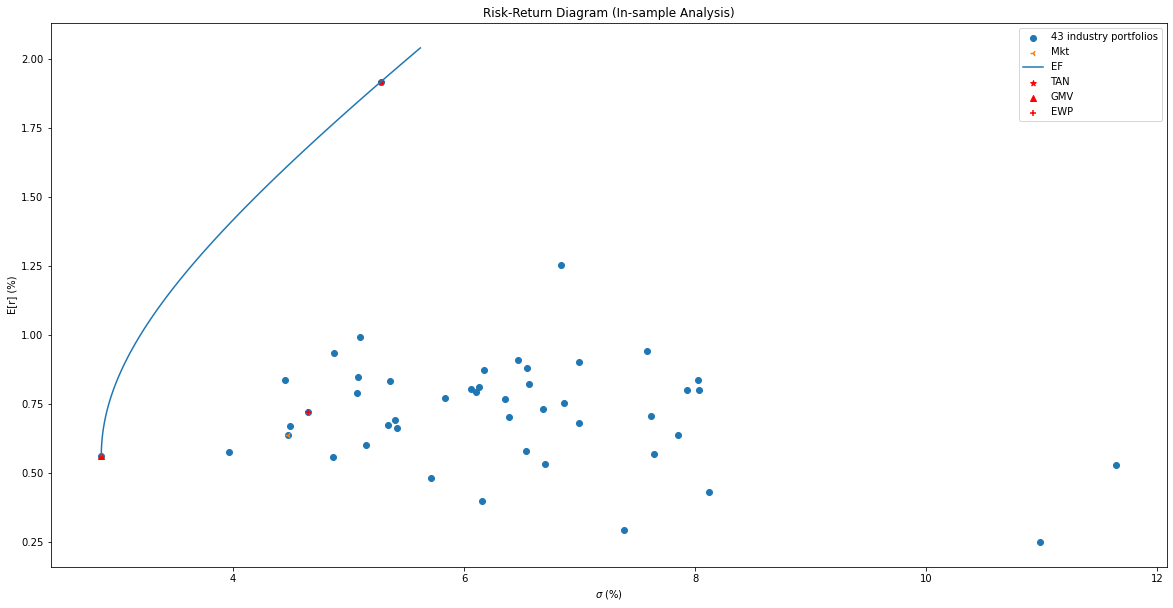

In [413]:
#a)
plt.figure(figsize=(20, 10))

#plot other 43 portfolios
portfolio_names = output.index
plt.scatter(output.iloc[:,1], output.iloc[:,0], label = "43 industry portfolios")
#plot market portfolio
plt.scatter(output.loc["Mkt", "Sigma"], output.loc["Mkt", "Er"], label = "Mkt", marker = "3")

#plot efficient frontier
plot_evaluation_results_in_sample(df.iloc[:, 3:46])



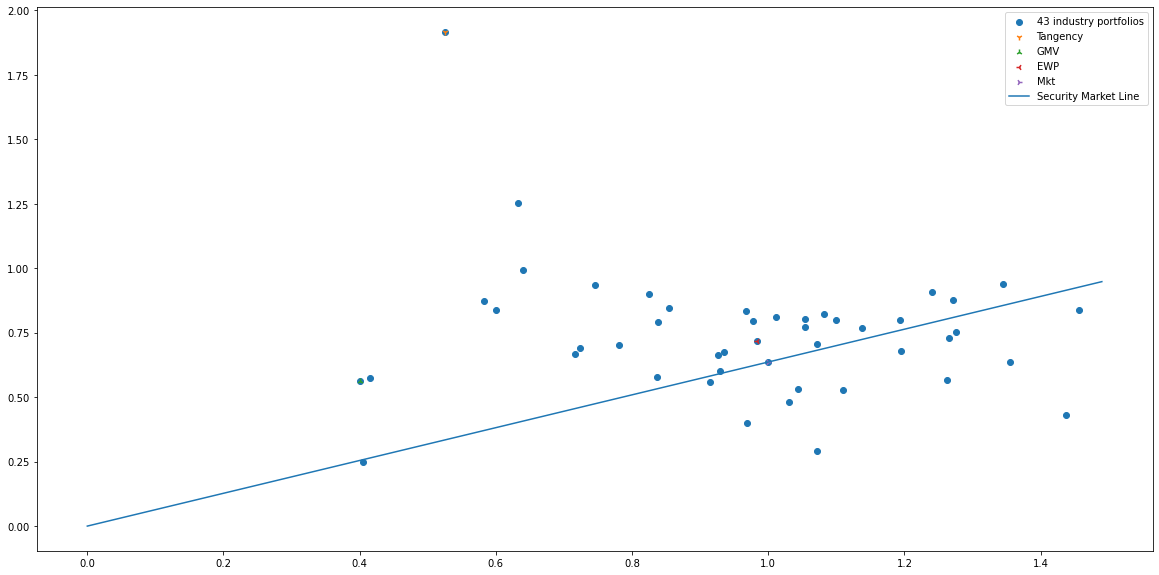

In [414]:
#b)
#calculate sml
beta_range = np.arange(0,1.5,0.01)
Er_range = beta_range * output.loc["Mkt", "Er"]

plt.figure(figsize = (20, 10))

#plot other 43 portfolios
plt.scatter(output.iloc[:,-1], output.iloc[:,0], label = "43 industry portfolios")

#plot other relevant portfolios
for i in range(43, 47):
    plt.scatter(output.iloc[i,-1], output.iloc[i,0], label = portfolio_names[i], marker = f"{i - 42}")

#plot SML
plt.plot(beta_range, Er_range, label = "Security Market Line")

plt.legend()

## 1.3.  Robust Portfolio Construction and Out-of-sample Analysis

In [415]:
#split into train and test
train = df.loc[df["Month"] <= 201012].drop(["GMV", "Tangency", "EWP"], axis = 1)
test = df.loc[df["Month"] >201012].drop(["GMV", "Tangency", "EWP"], axis = 1)

#function to calculate beta for each dataset, assuming market-risk free is in col 1 and other assets are in col 3 + i, 0 <= i <= 42
def get_beta(df):
    beta = []
    for i in range(43):
        covMatrix = EmpiricalCovariance().fit(train.iloc[:, [1, 3 + i]]).covariance_
        beta.append(covMatrix[0, 1]/covMatrix[0,0])

    return np.array(beta)

#function to plot efficient frontier
def plot_ef(wt_t, wt_gmv, V, mu, label):
    trange = np.arange(0,3,0.01)
    sigma_range = []
    er_range = []

    mu = mu.reshape(-1)

    for i in trange:
        wt_mix = i * wt_t + (1 - i) * wt_gmv
        var = wt_mix.T @ V @ wt_mix
        sigma_range.append(var ** 0.5)
        er_range.append(wt_mix.T @ mu)
    plt.plot(sigma_range, er_range, label = label)

 Estimating Beta. We will use the following shrinkage estimator of beta:
 <br>
βshrink = 0.5β¯ + 0.5β. ˆ
<br>
<br>
In the expression above, β¯ =
1
43
∑43
i=1 βˆ
i
is the grand average of beta across industries, βˆ is the
beta vector directly estimated from the sample covariance with MKT, and 0.5 is the shrinkage
constant that has been determined for you.


In [416]:
#calculate shrinked beta
beta_hat = get_beta(train)
beta_bar = np.mean(beta_hat)
shrinked_beta = 0.5 * beta_bar + 0.5 * beta_hat
shrinked_beta

array([0.85701587, 0.78554777, 0.91878221, 0.81845334, 0.80050887,
       1.0043332 , 1.1510755 , 0.99439164, 0.84918986, 1.04182083,
       0.89464713, 0.90973707, 0.85773813, 0.99398656, 1.01006935,
       1.07774378, 1.03878029, 1.07091068, 1.20400211, 1.00267582,
       1.1096002 , 1.10613155, 1.10933726, 0.99626296, 0.98560381,
       0.77305909, 0.69524505, 1.01189852, 1.02162797, 0.82121896,
       0.69609359, 0.95303175, 0.94852694, 1.13814019, 1.18307503,
       1.23344361, 1.13174117, 0.94301642, 0.96128002, 0.95229254,
       0.94161219, 0.98065442, 0.9131609 ])

Estimating Expected Return. Since estimating the expected return of an asset is a notoriously
difficult task, we will impose two layers of robustness in the estimation:
<br>
- First, we will use the CAPM-based expected return. That is the expected return implied
by CAPM that only depends on the value of beta.
<br>
- Second, we will use the robust estimation of beta itself; please see above

In [417]:
#calculate expected returns (qn: is this what's referred to as "robust estimation of beta"?)
capm_returns = shrinked_beta * train["Mkt-RF"].mean()
capm_returns

array([0.48118584, 0.44105889, 0.51586558, 0.45953427, 0.44945905,
       0.56389961, 0.64629052, 0.55831776, 0.4767918 , 0.58494767,
       0.50231454, 0.51078704, 0.48159137, 0.55809032, 0.56712027,
       0.6051172 , 0.58324051, 0.60128065, 0.67600705, 0.56296905,
       0.62300352, 0.62105599, 0.62285589, 0.55936844, 0.55338369,
       0.43404691, 0.39035692, 0.56814729, 0.57361005, 0.46108707,
       0.39083335, 0.53509556, 0.53256626, 0.63902778, 0.66425719,
       0.69253747, 0.63543494, 0.52947229, 0.53972669, 0.53468052,
       0.52868386, 0.55060477, 0.5127094 ])

Estimating covariance matrix. We will use the following shrinkage estimator of covariance matrix:
<br>
Vshrink = 0.3V
CC + 0.7V . ˆ
<br>
<br>
In the expression above, V
CC is the constant correlation matrix estimated from data, Vˆ is the
sample covariance matrix, and 0.3 is the shrinkage constant that has been determined for you.


In [418]:
#calculate Vhat
V_hat = train.iloc[:, 3:].cov()

#calculate average correlation
grand_avg_corr = 0
correlations = train.iloc[:, 3:].corr()
for i in range(43):
    grand_avg_corr += np.sum(correlations.iloc[i, i + 1:])
grand_avg_corr /= (43 * (43 - 1)) / 2

#calculate Vcc
Vcc = V_hat/correlations * grand_avg_corr

# convert the diagonal entires back into their original covariance
for i in range(43):
    Vcc.iloc[i,i] = V_hat.iat[i,i]

#calculate V_shrink
V_shrink = 0.3 * Vcc + 0.7 * V_hat
V_shrink.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals
Agric,42.451075,12.777359,17.209770,14.250394,16.219475,18.914251,22.638322,18.296609,13.223025,20.850108,...,20.903907,21.584443,23.892899,22.037766,16.420213,18.782065,17.231559,16.281772,17.546442,16.058984
Food,12.777359,21.779965,17.443900,15.594761,18.491971,16.165161,17.568479,14.612466,13.324245,17.727510,...,13.496575,12.765217,13.542835,14.209125,13.929295,14.572044,13.161099,13.146036,14.960421,14.271160
Soda,17.209770,17.443900,55.908805,22.182191,20.202499,23.873275,29.542519,22.979945,19.239053,25.678783,...,21.233660,22.694546,25.323608,24.002609,21.703203,21.708653,20.390975,20.700827,20.286513,20.347367
Beer,14.250394,15.594761,22.182191,29.627435,17.614668,18.133782,19.659889,14.860450,16.521366,18.113976,...,15.614236,15.218682,16.755136,16.111384,16.074474,16.009318,15.115613,13.786886,16.046628,16.005152
Smoke,16.219475,18.491971,20.202499,17.614668,52.002929,19.335637,21.328569,16.091168,15.338208,19.056979,...,16.705665,17.801113,17.488624,18.884657,17.748387,18.127234,14.123070,17.852719,14.949859,15.885271


Second, with the robust estimation of parameters, we may construct the following robust version
of portfolios:
<br>
<br>
• TAN-robust: The tangency portfolio using Vshrink and µ
CAPM as problem inputs;
<br>
• GMV-robust: The global minimum variance portfolio using Vshrink as the problem input.
<br>
<br>
In other words, the (only) difference between TAN and TAN-robust is the input parameters (i.e.,
expected return and covariance matrix), and we do not disturb the mathematical optimization problem
itself. A similar thing can be said between GMV and GMV-robust

In [419]:
#er of testing set
er_train = train.iloc[:, 3:].mean()

#get tangency robust wt
wt_tan_robust_tr = np.linalg.inv(V_shrink) @ capm_returns
wt_tan_robust_tr /= np.sum(wt_tan_robust_tr)

#get gmv robust wt
wt_gmv_robust_tr = np.linalg.inv(V_shrink) @ np.ones(43)
wt_gmv_robust_tr /= np.sum(wt_gmv_robust_tr)

#get tangency wt
wt_tan_tr = np.linalg.inv(V_hat) @ er_train
wt_tan_tr /= np.sum(wt_tan_tr)

#get gmv wt
wt_gmv_tr = np.linalg.inv(V_hat) @ np.ones(43)
wt_gmv_tr /= np.sum(wt_gmv_tr)

#ewp wt
wt_ewp = np.ones(43)/43

Finally, we can compare the six different portfolio constructions (MKT, EWP, TAN, TAN-robust,
GMV, and GMV-robust) in an out-of-sample study. In this section, let us perform a simple version of the out-of-sample analysis. That is, we break
the data into two components:
<br>
<br>
• The training data correspond to the first 25 years, i.e., years 1986-2010.
<br>
• The test data correspond to the last 5 years, i.e., years 2011-2015.
<br>
<br>
In the out-of-sample analysis, we construct the portfolios from the training data but evaluate them
on the test data.

In [420]:
#er of training set
er_test = test.iloc[:, 3:].mean()

#cov matrix of training set
V_test = EmpiricalCovariance().fit(test.iloc[:, 3:]).covariance_

#get tangency wt
wt_tan_te = np.linalg.inv(V_test) @ er_test
wt_tan_te /= np.sum(wt_tan_te)

#get gmv wt
wt_gmv_te = np.linalg.inv(V_test) @ np.ones(43)
wt_gmv_te /= np.sum(wt_gmv_te)

Deliverable.
<br>
1. The out-of-sample σ vs. E[r] diagram. This diagram includes all of the 43 industry portfolios
(treated as risky assets), MKT, and the special portfolios constructed from training data (EWP,
TAN, GMV, TAN-robust, and GMV-robust). All of them are evaluated on the test data. Also,
please include the “true” and “realized” EF curves.


In [496]:
data_portfolios = {
    "gmv true": [wt_gmv_te @ er_test, (wt_gmv_te.T @ V_test @ wt_gmv_te) ** 0.5],
    "tan true": [wt_tan_te @ er_test, (wt_tan_te.T @ V_test @ wt_tan_te) ** 0.5],
    "gmv realized (non-robust)": [wt_gmv_tr @ er_test, (wt_gmv_tr.T @ V_test @ wt_gmv_tr) ** 0.5],
    "tan realized (non-robust)": [wt_tan_tr @ er_test, (wt_tan_tr.T @ V_test @ wt_tan_tr) ** 0.5],
    "gmv realized (robust)": [wt_gmv_robust_tr @ er_test, (wt_gmv_robust_tr.T @ V_test @ wt_gmv_robust_tr) ** 0.5],
    "tan realized (robust)": [wt_tan_robust_tr @ er_test, (wt_tan_robust_tr.T @ V_test @ wt_tan_robust_tr) ** 0.5],
    "EWP": [wt_ewp @ er_test, (wt_ewp.T @ V_test @ wt_ewp) ** 0.5],
    "MKT": [test.iloc[:, 1].mean(), test.iloc[:, 1].std()]
}

#add sharpe ratio
for k, v in data_portfolios.items():
    data_portfolios[k].append(v[0]/v[1])

data_industries = {
    "industries": test.columns,
    "sigma": test.iloc[:, 3:].std(axis = 0),
    "Er": test.iloc[:, 3:].mean(axis = 0)
}

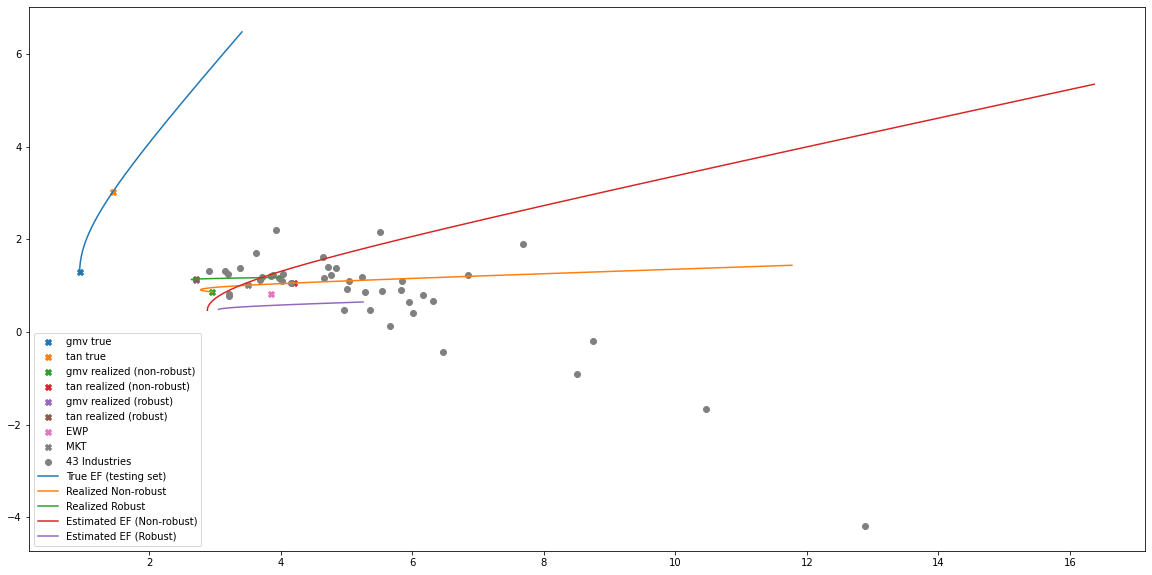

In [497]:
plt.figure(figsize = (20, 10))

#plot each pair of gmv and tan portfolios
for k, v in data_portfolios.items():
    plt.scatter(v[1], v[0], label = k, marker = "X")

#plot all assets
plt.scatter(data_industries["sigma"], data_industries["Er"], label = "43 Industries", c = "grey")

#true ef - ef of tan and gmv portfolios constructed using the testing set itself
plot_ef(wt_tan_te, wt_gmv_te, V_test, er_test.values, label = "True EF (testing set)")

#realized non-robust - ef of tan and gmv portfolios constructed from training set but optimized using covariance and er of testing set
plot_ef(wt_tan_tr, wt_gmv_tr, V_test, er_test.values, label = "Realized Non-robust")

#realized robust - ef of tan and gmv portfolios constructed from training set with shrinkage parameters but optimized using covariance and er of testing set
plot_ef(wt_tan_robust_tr, wt_gmv_robust_tr, V_test, er_test.values, label = "Realized Robust")

#estimated ef using training data - non-robust
plot_ef(wt_tan_tr, wt_gmv_tr, V_hat, er_train.values, label = "Estimated EF (Non-robust)")

#estimated ef using training data - robust
plot_ef(wt_tan_robust_tr, wt_gmv_robust_tr, V_hat, er_train.values, label = "Estimated EF (Robust)")

plt.legend()

2. Compare the out-of-sample performances of MKT, EWP, TAN, TAN-robust, GMV, and GMVrobust using the definitions and methods introduced above. Report your results in a 3 by 6
table. (Recall that we have 3 performance metrics and 6 portfolios to compare.)


In [504]:
#Filter and generate a DataFrame
data_portfolios2 = {k: v for k, v in data_portfolios.items() if k in ["MKT", "EWP", "tan realized (non-robust)", "gmv realized (non-robust)", "tan realized (robust)", "gmv realized (robust)"]}
summary_table = pd.DataFrame.from_dict(data_portfolios2, orient='index', columns=["Er", "Sigma", "Sharpe"]).T
summary_table

,gmv realized (non-robust),tan realized (non-robust),gmv realized (robust),tan realized (robust),EWP,MKT
Er,0.863082,1.055857,1.122783,1.141517,0.822671,1.010833
Sigma,2.963800,4.201550,2.708489,2.712153,3.858277,3.502378
Sharpe,0.291208,0.251302,0.414542,0.420890,0.213222,0.288613


3. Contrast the table for out-of-sample performance with that for in-sample performance. What
are your findings and insights? Also, are there any limitations to the current evaluation methodology?


In [509]:
data_insample = {
    "in-sample gmv (non-robust)": [wt_gmv_tr @ er_train, (wt_gmv_tr.T @ V_hat @ wt_gmv_tr) ** 0.5],
    "in-sample tan (non-robust)": [wt_tan_tr @ er_train, (wt_tan_tr.T @ V_hat @ wt_tan_tr) ** 0.5],
    "in_sample gmv (robust)": [wt_gmv_robust_tr @ er_train, (wt_gmv_robust_tr.T @ V_hat @ wt_gmv_robust_tr) ** 0.5],
    "in-sample tan (robust)": [wt_tan_robust_tr @ er_train, (wt_tan_robust_tr.T @ V_hat @ wt_tan_robust_tr) ** 0.5],
    "EWP": [wt_ewp @ er_train, wt_ewp.T @ V_hat @ wt_ewp],
    "MKT": [train.iloc[:, 1].mean(), train.iloc[:, 1].std(),],
}

#calculate sharpe
for k, v in data_insample.items():
    data_insample[k].append(v[0]/v[1])

summary_table2 = pd.DataFrame.from_dict(data_insample, orient = 'index', columns = ["Er", "Sigma", "Sharpe"]).T
summary_table2

,in-sample gmv (non-robust),in-sample tan (non-robust),in_sample gmv (robust),in-sample tan (robust),EWP,MKT
Er,0.467903,2.100185,0.486128,0.539942,0.697483,0.561467
Sigma,2.885562,6.113378,3.055273,3.412344,23.048278,4.657505
Sharpe,0.162153,0.343539,0.159111,0.158232,0.030262,0.120551


Answer: ___